In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.db_connect_pudl()

## Import Tables Needed

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9 , 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)
bga8.drop_duplicates(['plant_id','boiler_id','generator_id'],inplace=True)

In [5]:
# get the primary fuel for each plant (to be used to combine plants that have unassociated generators)
gf9 = analysis.simple_select('generation_fuel_eia923', pudl_engine)
primary_fuel9 = analysis.primary_fuel_gf_eia923(gf9).rename(columns={'year':'report_date'})

In [6]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_plant_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date'])
bf9_plant_summed.reset_index(inplace=True)

## Unassociated Generators

In [7]:
# This section generates heat rate from the generators
# of the plants that have any generators that are not
# included in the boiler generator association table (860)
# Because there are missing generators in the bga table,
# without lumping all of the heat input and generation
# from these plants together, the heat rates were off. 
# The vast majority of missing generators from the bga
# table seem to be the gas tubrine from combine cycle plants.
# This was generating heat rates for the steam generators
# alone, therefor much too low.

In [8]:
# All cenerators from the Boiler Generator Association table (860)
gens8 = bga8.drop_duplicates(subset=['plant_id','generator_id'])
# All cenerators from the generation table (923)
gens9 = g9_summed.drop_duplicates(subset=['plant_id','generator_id','report_date'])

# See which generators are missing from the bga table
gens = gens9.merge(gens8, on=['plant_id', 'generator_id'], how="left")
gens.boiler_id = gens.boiler_id.astype(str)
gens['boiler_generator_assn'] = np.where(gens['boiler_id']=='nan', False, True)

# Create a list of plants that include any generators that are not in the bga table
unassociated_plants = gens[gens['boiler_generator_assn'] == False].\
                      drop_duplicates(subset=['plant_id','report_date']).\
                      drop(['generator_id', 'net_generation_mwh','boiler_id','boiler_generator_assn'],axis=1)
unassociated_plants['plant_assn'] = False

# Using these unassociated_plants, lable all the generators that
# are a part of plants that have generators that are not included
# in the bga table
gens = gens.merge(unassociated_plants, on=['plant_id','report_date'],how='left')
gens['plant_assn'] = gens.plant_assn.fillna(value=True)

# Get a list of generators from plants with unassociated plants
gens_unassn_plants = gens[gens['plant_assn'] == False]

# Sum the yearly net generation for these plants
gup_gb = gens_unassn_plants.groupby(by=['plant_id','report_date'])
gens_unassn_plants_summed = gup_gb.agg({'net_generation_mwh': np.sum})
gens_unassn_plants_summed.reset_index(inplace=True)

# Pull in mmbtu to calculate heat rate by plant
unassn_plants = gens_unassn_plants_summed.merge(bf9_plant_summed, on=['plant_id','report_date'])
unassn_plants['heat_rate_mmbtu_mwh'] = unassn_plants['fuel_consumed_mmbtu'] / unassn_plants['net_generation_mwh']

# Merge these plant level heat heat rates with the unassociated generators
# Assign heat rates to generators across the plants with unassociated generators
heat_rate_unassn = gens_unassn_plants.merge(unassn_plants[['plant_id','report_date','heat_rate_mmbtu_mwh']], on=['plant_id','report_date'],how='left')
heat_rate_unassn.drop(['boiler_id','boiler_generator_assn'],axis=1,inplace=True)

## Associated Generators

In [9]:
# This section generates heat rate from the generators of
# the plants that have any generators that are included in
# the boiler generator association table (860)

In [22]:
generation_w_boilers = g9_summed.merge(bga8,how='left',on=['plant_id','generator_id'])

# get net generation per boiler
gb1 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id'])
generation_w_boilers_summed = gb1.agg({'net_generation_mwh': np.sum})
generation_w_boilers_summed.reset_index(inplace=True)
generation_w_boilers_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler'}, inplace=True)

# get the generation per boiler/generator combo
gb2 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id','generator_id'])
generation_w_bg_summed = gb2.agg({'net_generation_mwh': np.sum})
generation_w_bg_summed.reset_index(inplace=True)
generation_w_bg_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler_gen'}, inplace=True)

# squish them together
generation_w_boilers_summed = generation_w_boilers_summed.merge(generation_w_bg_summed,
                                                                how='left', on=['plant_id','report_date','boiler_id'])

# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])
bg = bg.merge(generation_w_boilers_summed, how='left', on=['plant_id','report_date', 'boiler_id', 'generator_id'])

# Use the proportion of the generation of each generator to allot mmBTU
bg['proportion_of_gen_by_boil_gen'] = bg['net_generation_mwh_boiler_gen'] / bg['net_generation_mwh_boiler']
bg['fuel_consumed_mmbtu_per_gen'] = bg['proportion_of_gen_by_boil_gen'] * bg['fuel_consumed_mmbtu']

# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu_per_gen':np.sum})
bg_summed.reset_index(inplace=True)

# Calculate heat rate
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu_per_gen'] / heat_rate['net_generation_mwh']

# Importing the plant association tag to filter out the
# generators that are a part of plants that aren't in the bga table
heat_rate = heat_rate.merge(gens[['plant_id','report_date','generator_id','plant_assn']], on=['plant_id','report_date','generator_id'])
heat_rate_assn = heat_rate[heat_rate['plant_assn'] == True]

In [25]:
heat_rate_assn[heat_rate_assn['plant_id'] == 3]

,plant_id,report_date,generator_id,fuel_consumed_mmbtu_per_gen,net_generation_mwh,heat_rate_mmbtu_mwh,plant_assn
0,3,2009,1,2.282135e+06,221908.0,10.284149,True
1,3,2009,2,4.047126e+06,394031.0,10.271086,True
2,3,2009,3,1.306599e+07,1286393.0,10.157073,True
3,3,2009,4,1.616073e+07,1626547.0,9.935606,True
4,3,2009,5,4.470910e+07,4513101.0,9.906513,True
5,3,2009,A1ST,1.760776e+05,1122697.0,0.156834,True
6,3,2009,A2ST,1.373917e+05,1033733.0,0.132908,True
7,3,2010,1,4.524332e+06,435334.0,10.392783,True
8,3,2010,2,5.721033e+06,538495.0,10.624116,True
9,3,2010,3,9.570256e+06,906322.0,10.559444,True


In [26]:
heat_rate_unassn[heat_rate_unassn['plant_id'] == 3]

,plant_id,report_date,generator_id,net_generation_mwh,plant_assn,heat_rate_mmbtu_mwh
0,3,2014,1,19614.0,False,8.041255
1,3,2014,2,18297.0,False,8.041255
2,3,2014,3,484643.0,False,8.041255
3,3,2014,4,1376293.0,False,8.041255
4,3,2014,5,3336696.0,False,8.041255
5,3,2014,A1CT,838358.0,False,8.041255
6,3,2014,A1CT2,849336.0,False,8.041255
7,3,2014,A1ST,1427836.0,False,8.041255
8,3,2014,A2C1,830654.0,False,8.041255
9,3,2014,A2C2,852641.0,False,8.041255


## Pull the Associated and Unassociated Generators

In [17]:
heat_rate_all = heat_rate_assn.append(heat_rate_unassn)

In [18]:
heat_rate_all

,fuel_consumed_mmbtu_per_gen,generator_id,heat_rate_mmbtu_mwh,net_generation_mwh,plant_assn,plant_id,report_date
0,2.282135e+06,1,10.284149,221908.0,True,3,2009
1,4.047126e+06,2,10.271086,394031.0,True,3,2009
2,1.306599e+07,3,10.157073,1286393.0,True,3,2009
3,1.616073e+07,4,9.935606,1626547.0,True,3,2009
4,4.470910e+07,5,9.906513,4513101.0,True,3,2009
5,1.760776e+05,A1ST,0.156834,1122697.0,True,3,2009
6,1.373917e+05,A2ST,0.132908,1033733.0,True,3,2009
7,4.524332e+06,1,10.392783,435334.0,True,3,2010
8,5.721033e+06,2,10.624116,538495.0,True,3,2010
9,9.570256e+06,3,10.559444,906322.0,True,3,2010


/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


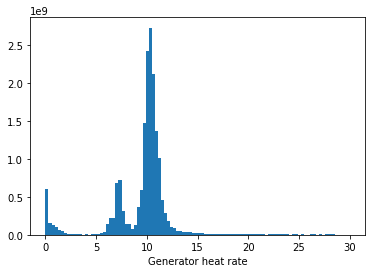

In [23]:
plt.hist(heat_rate_all.heat_rate_mmbtu_mwh, range=[0,30],bins=100,weights=heat_rate_all.net_generation_mwh)
#heat_rate['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[-20,70])
plt.xlabel('Generator heat rate')
plt.show()